In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



In [116]:
skyhook_col_types = {
"tide5id_100m" : str,
"mac_oui" : str,
"ssid" : str,
"lat" : float,
"lon" : float ,
"rq_time" : str, # we parse this as date with parse_dates parameter in read_csv call later
"zcta" : int,
"zcta_city" : str,
"zcta_county" : str,
"zcta_state" : str
}

skyhook_data = pd.read_csv("../data/skyhook/p1059_nau_oui_20210301.csv", dtype=skyhook_col_types, parse_dates=['rq_time'])

In [117]:
skyhook_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291723 entries, 0 to 1291722
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   tide5id_100m  1291723 non-null  object        
 1   mac_oui       1291723 non-null  object        
 2   ssid          175251 non-null   object        
 3   lat           1291723 non-null  float64       
 4   lon           1291723 non-null  float64       
 5   rq_time       1291723 non-null  datetime64[ns]
 6   zcta          1291723 non-null  int64         
 7   zcta_city     1291723 non-null  object        
 8   zcta_county   1291723 non-null  object        
 9   zcta_state    1291723 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 98.6+ MB


In [118]:
skyhook_data_timesort = skyhook_data.sort_values('rq_time')

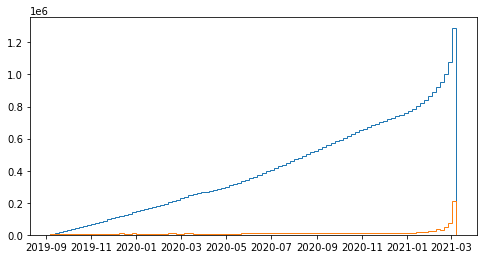

In [119]:
# skyhook_data['rq_time'].plot()
# weekly bins, get first and last days, find number of days, divide by 
num_bin = 100
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(skyhook_data_timesort['rq_time'], num_bin, cumulative=True, histtype='step')
ax.hist(skyhook_data_timesort['rq_time'], num_bin, histtype='step')
plt.show()

<class 'pandas.core.series.Series'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


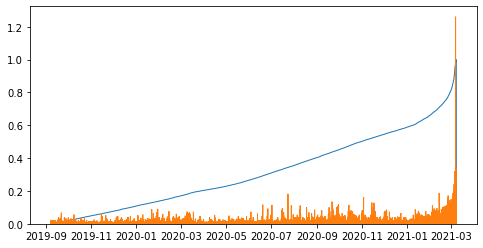

In [120]:
ts = skyhook_data_timesort['rq_time']
print(type(ts))
print(type(ts[1]))
ts[1]
series = pd.Series(ts.index, ts.values)

series.resample('7d').count()


num_bin = series.size
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(skyhook_data_timesort['rq_time'], num_bin, density=True, cumulative=True, histtype='step')
ax.hist(skyhook_data_timesort['rq_time'], num_bin, density=True,histtype='step')
plt.show()
# ts.resample(pd.Timedelta('7d')).count()

In [121]:

rng = pd.date_range("1/1/2012", periods=100, freq="S")
ts = pd.Series(np.random.randint(0,500,len(rng)), index=rng)
type(ts)
print(type(ts[1]))
ts[1]

ts.resample('5min').sum()

<class 'numpy.int64'>


2012-01-01    24159
Freq: 5T, dtype: int64

In [130]:
print(skyhook_data[['rq_time']].describe(datetime_is_numeric=True))

weekly_counts = skyhook_data.resample('7d', on='rq_time').count()


num_bin = weekly_counts.size
fig, ax = plt.subplots()
ax.hist(range(0,num_bin), num_bin, weights=weekly_counts['zcta'], cumulative=True, histtype='step')
ax.hist(range(0,num_bin), num_bin, histtype='step')
plt.show()
counts, bins = np.histogram(weekly_counts)
weekly_counts.info

                             rq_time
count                        1291723
mean   2020-09-17 07:06:19.692180224
min              2019-09-07 00:04:19
25%       2020-05-20 19:33:33.500000
50%              2020-10-29 23:15:28
75%       2021-02-21 01:56:43.500000
max              2021-03-07 23:59:52


ValueError: weights should have the same shape as x

In [131]:
print(skyhook_data[['rq_time']].describe(datetime_is_numeric=True))

weekly_counts = skyhook_data.resample('7d', on='rq_time').count()
weekly_counts['rq_time']
weekly_counts.shape



                             rq_time
count                        1291723
mean   2020-09-17 07:06:19.692180224
min              2019-09-07 00:04:19
25%       2020-05-20 19:33:33.500000
50%              2020-10-29 23:15:28
75%       2021-02-21 01:56:43.500000
max              2021-03-07 23:59:52


(79, 10)